In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
import sys
sys.path.append('..')
from transformers import AutoModelForSequenceClassification
from modeling_rmt import RMTEncoderForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from modeling_rmt import RMTEncoderForSequenceClassification
from modeling_rmt import *
from modeling_rmt.experimental import RMTEncoderDecoderFullMemoryLastSeg

In [3]:
num_segments = 2
num_mem_tokens = 25
# device = torch.device(3)
device = 'cpu'

In [4]:
# model_name = 'bert-base-cased'
model_name = 't5-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': num_mem_tokens, 
                'max_n_segments': num_segments,
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
               #  'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

# base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
base_model = T5ForConditionalGeneration.from_pretrained(model_name)
rmt = RMTEncoderDecoderFullMemoryLastSeg(base_model, **rmt_config)

t5 = T5ForConditionalGeneration.from_pretrained(model_name)
# rmt = RMTEncoderTBPTT(base_model, **rmt_config)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


In [5]:
# cpt_path = "../../runs/framework/qasper/t5-base/lr5e-05_constant_with_warmup_adamw_wd1e-03_1024-1024-{2}seg_mem25_bs32_iters6000_regular_full_mem_last_seg/run_1/model_best.pth"
cpt_path = "../../runs/framework/qasper/t5-base/lr5e-05_constant_with_warmup_adamw_wd1e-03_1024-1024-{2}seg_mem25_bs32_iters3000_regular_full_mem_last_seg_fix_gen/run_1/model_best.pth"
cpt = torch.load(cpt_path, map_location='cpu')
rmt.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

In [6]:
cpt_path = "../../runs/framework/qasper/t5-base/lr5e-05_constant_with_warmup_adamw_wd1e-03_512-1024-{1}seg_memNA_bs32_iters5000_regular/run_10/model_best.pth"
cpt = torch.load(cpt_path, map_location='cpu')
t5.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

### load dataset 

In [7]:
class Holder:
    def __init__(self):
        pass

In [8]:
input_seq_len = 1024
target_seq_len = 1024
batch_size = 1

args = Holder
args.num_mem_tokens = 25
args.max_n_segments = 2
args.input_size = 512
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [9]:
# answers = train_dataset.choices_dict['places']
# labels_map = dict(zip(answers, range(len(answers))))
# num_labels = len(labels_map)
# if args.num_mem_tokens is None:
#     input_seg_size = args.input_size
# else:
#     input_seg_size = args.input_size - args.num_mem_tokens - tokenizer.num_special_tokens_to_add()
#     if 'sep_token' in tokenizer.special_tokens_map:
#         input_seg_size -= 1


### enc-dec

In [10]:
global_attention_first_token = False  # should be True for LED
encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
generate_kwargs = {}

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    if 'outputs' in batch[0]:
        # if we have more than 1 label per example (only in valid) take only one of them
        # to compute loss on valid
        labels = [b['outputs'][0][:args.target_seq_len * 10] for b in batch]
    else:
        labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), max_length=args.input_seq_len, return_tensors='pt',
                                           **encode_plus_kwargs)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
                                             **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    features['id'] = [b['id'] for b in batch]
    if 'outputs' in batch[0]:
        features['target_text'] = [b['outputs'] for b in batch]
    else:
        features['target_text'] = [b['output'] for b in batch]
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features

In [11]:
task_name = 'qasper'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/qasper/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
# gen = iter(train_dataloader)
gen = iter(valid_dataloader)
sample = next(gen)

if 'id' in sample:
    id = sample.pop('id')
if 'target_text' in sample:
    tgt_text = sample.pop('target_text')

rmt.to(device)
for k in sample:
    sample[k] = sample[k].to(device)
    
sample_input_ids = sample.pop('input_ids').to(device)
kwargs = sample

In [24]:
rmt_out = rmt(sample_input_ids, **kwargs)
rmt_out.loss

tensor(5.5854, grad_fn=<NllLossBackward>)

In [14]:
t5_out = t5(sample_input_ids, **kwargs)
t5_out.loss

tensor(4.5308, grad_fn=<NllLossBackward>)

In [77]:
# rmt_out.loss, t5_out.loss

In [26]:
rmt_generated = rmt.generate(sample_input_ids)
# rmt_generated_ = generate_(rmt, sample_input_ids)
t5_generated = t5.generate(sample_input_ids)

In [29]:
tgt_text, tokenizer.decode(rmt_generated[0]), tokenizer.decode(t5_generated[0])

(['Based on table results provided changing directed to undirected edges had least impact - max abs difference of 0.33 points on all three datasets.'],
 '<pad> No</s>',
 '<pad> a loss of weight $<unk>mathbf <unk>h<unk>_v<unk>t')

In [33]:
samples = []
for _ in range(10):
    sample = next(gen)
    samples.append(sample)
    if 'id' in sample:
        id = sample.pop('id')
    if 'target_text' in sample:
        tgt_text = sample.pop('target_text')
    sample_input_ids = sample.pop('input_ids').to(device)
    kwargs = sample
    
    rmt_out = rmt(sample_input_ids, **kwargs)
    t5_out = t5(sample_input_ids, **kwargs)

    rmt_generated = rmt.generate(sample_input_ids)
    # rmt_generated_ = generate_(rmt, sample_input_ids)
    t5_generated = t5.generate(sample_input_ids)

    print(rmt_out.loss, t5_out.loss)
    print(tgt_text, tokenizer.decode(rmt_generated[0]), tokenizer.decode(t5_generated[0]))
    print()

tensor(1.9843, grad_fn=<NllLossBackward>) tensor(0.4621, grad_fn=<NllLossBackward>)
['TripAdvisor'] <pad> Unanswerable</s> <pad> The reviews we used have been extracted from TripAdvisor and originally proposed in BIBRE

tensor(3.0885, grad_fn=<NllLossBackward>) tensor(3.0750, grad_fn=<NllLossBackward>)
['encodes the information from audio and text sequences using dual RNNs and then combines the information from these sources using a feed-forward neural model'] <pad> No</s> <pad> they combine text sequences from a variety of sources, including audio and video transcripts</s>

tensor(0.4026, grad_fn=<NllLossBackward>) tensor(0.5931, grad_fn=<NllLossBackward>)
['Unanswerable'] <pad> Unanswerable</s> <pad> StackExchange StackExchange dataset contains 106,716 words</s>

tensor(1.3923, grad_fn=<NllLossBackward>) tensor(0.2937, grad_fn=<NllLossBackward>)
['Yes'] <pad> Unanswerable</s> <pad> Yes</s>

tensor(3.5026, grad_fn=<NllLossBackward>) tensor(3.8890, grad_fn=<NllLossBackward>)
['It learn

In [ ]:
tgt_text, tokenizer.decode(rmt_generated[0]), tokenizer.decode(t5_generated[0])

(['26972 sentences'], '<pad> Yes</s>', '<pad> 70,000 sentences</s>')

In [ ]:
def generate_(self, input_ids, **kwargs):
    memory = self.set_memory(input_ids.shape)
    segmented = self.pad_and_segment(input_ids)

    memories = []
    for seg_num, segment_input_ids in enumerate(segmented):                
        if self.rmt_config['bptt_depth'] != -1:
            raise NotImplementedError

        seg_kwargs, non_empty_mask = self.prepare_kwargs(segment_input_ids, kwargs)
        if sum(non_empty_mask) == 0:
            continue
        seg_kwargs['inputs_embeds'][:, self.memory_position] = memory[non_empty_mask]

        for param in ['min_length', 'max_length']:
            if param in seg_kwargs:
                seg_kwargs.pop(param)
                
        encoder_out = self.model.encoder(**seg_kwargs)
        memory[non_empty_mask] = encoder_out.last_hidden_state[:, self.memory_position]
        memories.append(torch.clone(memory))

    hidden_states = torch.cat(memories[:-1] + [encoder_out.last_hidden_state], dim=1)
    encoder_out.hidden_states = None
    encoder_out.last_hidden_state = hidden_states
    out = self.model.generate(encoder_outputs=encoder_out)
    return out 

In [36]:
input_ids = torch.clone(sample_input_ids)
gen_kwargs = dict(**kwargs)
gen_kwargs.pop('labels')

generated = generate_(rmt, input_ids, **gen_kwargs)
tokenizer.decode(generated[0])

tensor([[   0,  597, 3247, 3321,  179,    1]])

In [18]:
tokenizer.decode(out[0])

'<pad> Unanswerable</s>'

In [ ]:
len(encoder_out.hidden_states), encoder_out.hidden_states[-1].shape

TypeError: object of type 'NoneType' has no len()

In [30]:
encoder_out.hidden_states = None
encoder_out.last_hidden_state = hidden_states

In [27]:
encoder_out.last_hidden_state.shape

torch.Size([1, 537, 768])

In [34]:
generated = self.model.generate(encoder_outputs=encoder_out)
tokenizer.decode(generated[0])

'<pad> Unanswerable</s>'

In [32]:
generated

tensor([[   0,  597, 3247, 3321,  179,    1]])

In [46]:
len(memories), memories[0].shape

(2, torch.Size([1, 25, 768]))

In [ ]:
out = self.model.generate(**seg_kwargs, encoder_hidden_states=hidden_states)


In [44]:
hidden_states[-1].shape

torch.Size([537, 768])

In [42]:
seg_kwargs.keys()

dict_keys(['attention_mask', 'input_ids', 'inputs_embeds', 'output_hidden_states'])

In [109]:
def metrics_fn(data):
    # compute metrics based on stored labels, predictions, ...
    metrics = {}
    y, p = None, None
    if args.model_type == 'encoder-decoder' and 'generation_outputs' in data:
        # replace -100 with pad token in labels
        y = data['labels']
        p = tokenizer.batch_decode(data['generation_outputs'], skip_special_tokens=True)
        if hvd.rank() == 0 and args.show_valid_examples > 0:
            for i in range(min(args.show_valid_examples, len(y))):
                logger.info(f'y: {y[i]}')
                logger.info(f'p: {p[i]}')
                logger.info(f'p ids: {data["generation_outputs"][i]}')
                logger.info('-' * 50)
        # todo: do we need to better clean P to remove tokens after eos? not remove special tokens only
    elif args.model_type == 'encoder':
        y, p = data['labels'], data['predictions']

    if y is not None and p is not None:
        if args.model_type == 'encoder-decoder':
            if not isinstance(y[0], list):
                y = [[_y] for _y in y]
            result = scrolls_metric.compute(predictions=p, references=y)
            for metric_name in task_to_metric[args.task_name]:
                metrics[metric_name] = result[metric_name]
        elif args.model_type == 'encoder' and args.task_name == 'contract_nli':
            metrics['exact_match'] = accuracy_score(y, p) * 100
            metrics['f1_micro'] = f1_score(y, p, average='micro')
    return metrics

In [114]:
out1['loss'], out2['loss']

(tensor(0.1718, grad_fn=<NllLossBackward>),
 tensor(1.8703, grad_fn=<NllLossBackward>))

### numeric comparison

### какая масса Attention приходится на память?

In [169]:
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]

memory_inds = range(1, 11)
cls_inds = [0]
mem_inds = np.where(np.array(tokens) == '')[0]
sep_inds = np.where(np.array(tokens) == '[SEP]')[0]
seg_inds = list(map(lambda x: x not in {'[SEP]', '[CLS]', '[PAD]', ''}, tokens))
# attentions1[0].sum(dim=1)

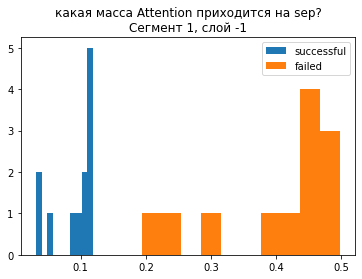

In [173]:
# какая масса Attention приходится на sep_inds?
layer = -1
segment = 0
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на sep?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, sep_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, sep_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

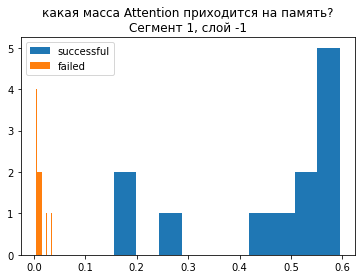

In [170]:
# какая масса Attention приходится на память?
layer = -1
segment = 0
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на память?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

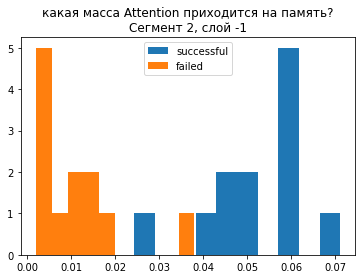

In [171]:
layer = -1
segment = 1
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на память?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

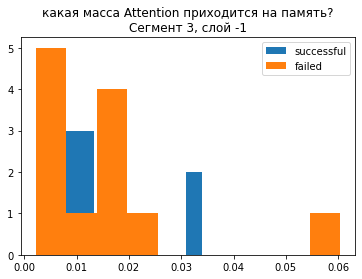

In [172]:
layer = -1
segment = 2
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на память?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

### losses

In [152]:
np.array(tokens)[mem_inds]

array(['', '', '', '', '', '', '', '', '', ''], dtype='<U11')

In [130]:
attentions1.shape

torch.Size([12, 180, 180])

In [121]:
out1['loss_0'].item(), out1['loss_1'].item(), out1['loss_2'].item()

(2.452950954437256, 2.322477102279663, 0.17180368304252625)

In [120]:
out2['loss_0'].item(), out2['loss_1'].item(), out2['loss_2'].item()

(1.9188117980957031, 1.9174211025238037, 1.8703436851501465)

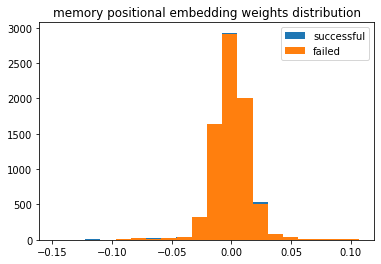

In [177]:
## embedding weights
memory_embeddings1 = rmt1.model.base_model.embeddings.position_embeddings.weight[1:11]
memory_embeddings2 = rmt2.model.base_model.embeddings.position_embeddings.weight[1:11]

plt.title('memory positional embedding weights distribution')
plt.hist(memory_embeddings1.flatten().detach(), bins=20)
plt.hist(memory_embeddings2.flatten().detach(), bins=20)

plt.legend(['successful', 'failed'])
plt.show()

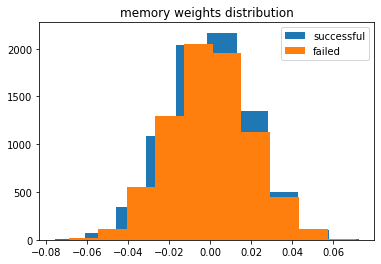

In [74]:
## memory weights
memory1 = rmt1.set_memory((1, 512))
memory2 = rmt2.set_memory((1, 512))

plt.title('memory weights distribution')
plt.hist(memory1.flatten().detach())
plt.hist(memory2.flatten().detach())

plt.legend(['successful', 'failed'])
plt.show()

### plot attentions


In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None):
    # attentions n_layers x n_heads x len x len
    attention = attentions.detach()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(sz, sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens)#, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [46]:
segmented = rmt.pad_and_segment(input_ids)

## failed seed

<Figure size 720x720 with 0 Axes>

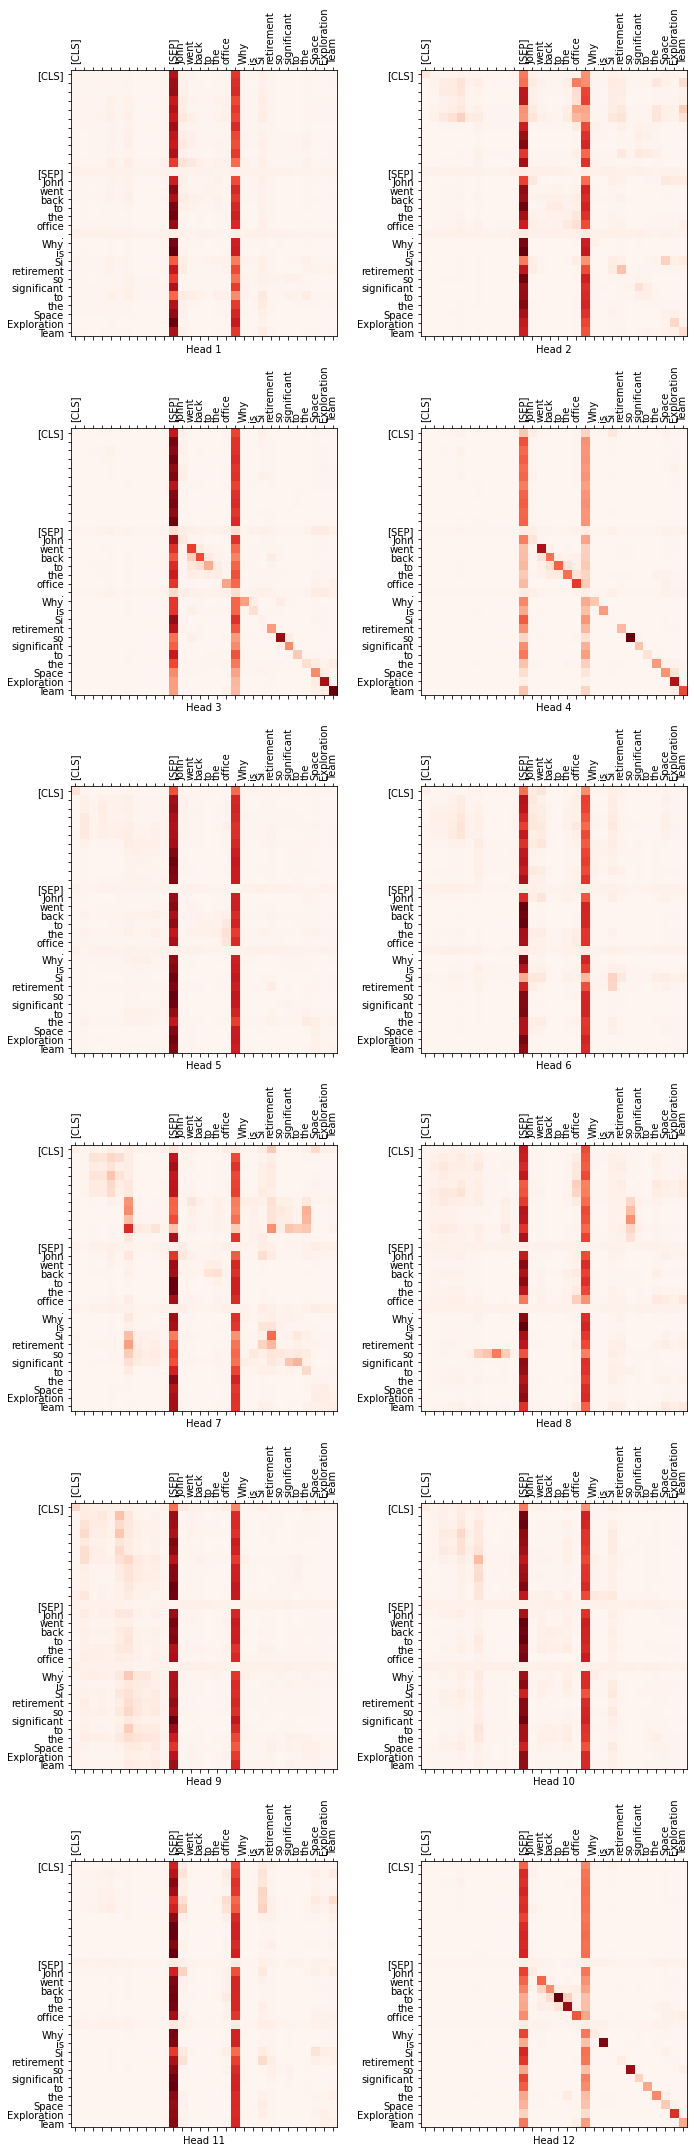

In [47]:
# seg 1
layer = -1
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

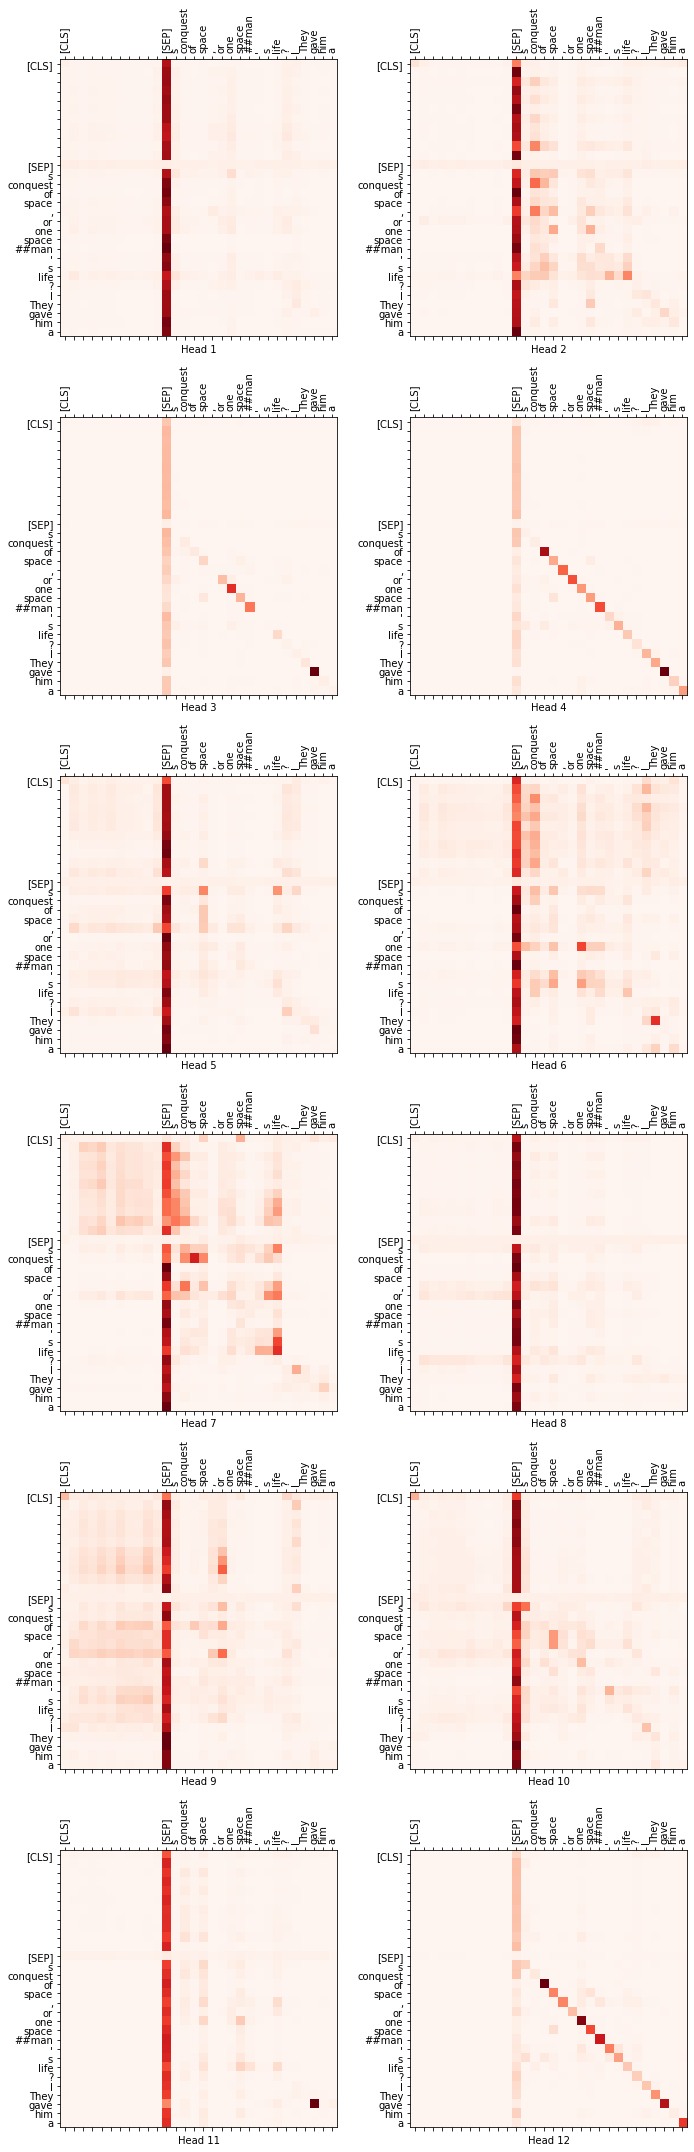

In [49]:
# seg 2
layer = -1
segment = 1
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

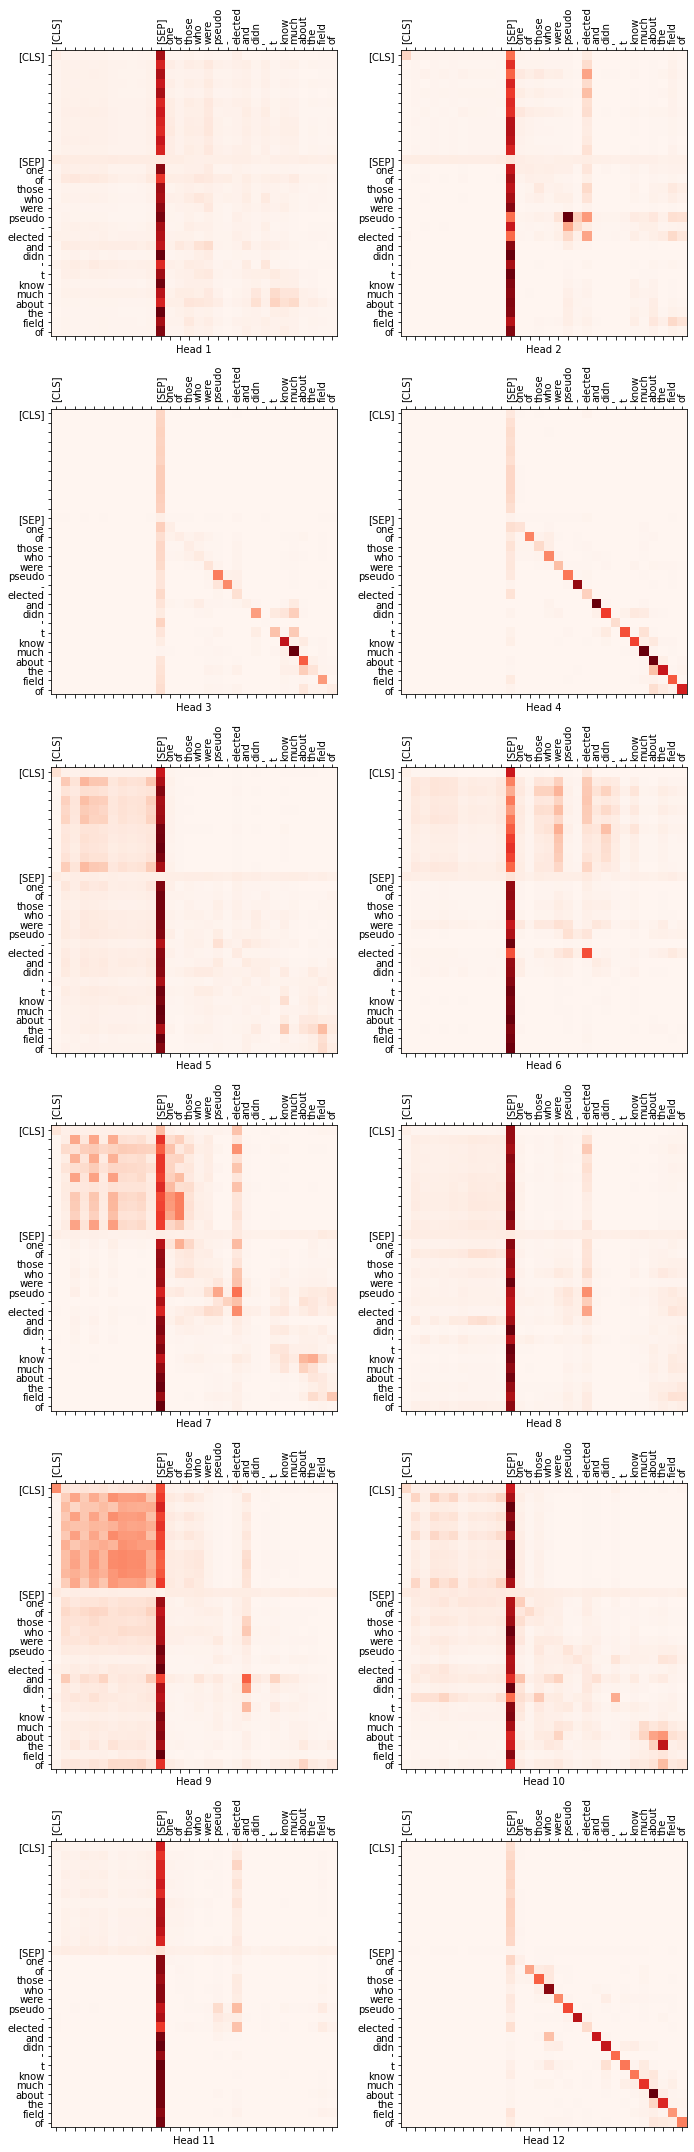

In [50]:
# seg 3
layer = -1
segment = 2
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

## successful seed

### seg1

In [80]:
len(attentions), attentions[0].shape

(12, torch.Size([2, 12, 180, 180]))

In [44]:
head = 0
attentions[layer][bn][head]

torch.Size([12, 180, 180])

<Figure size 720x720 with 0 Axes>

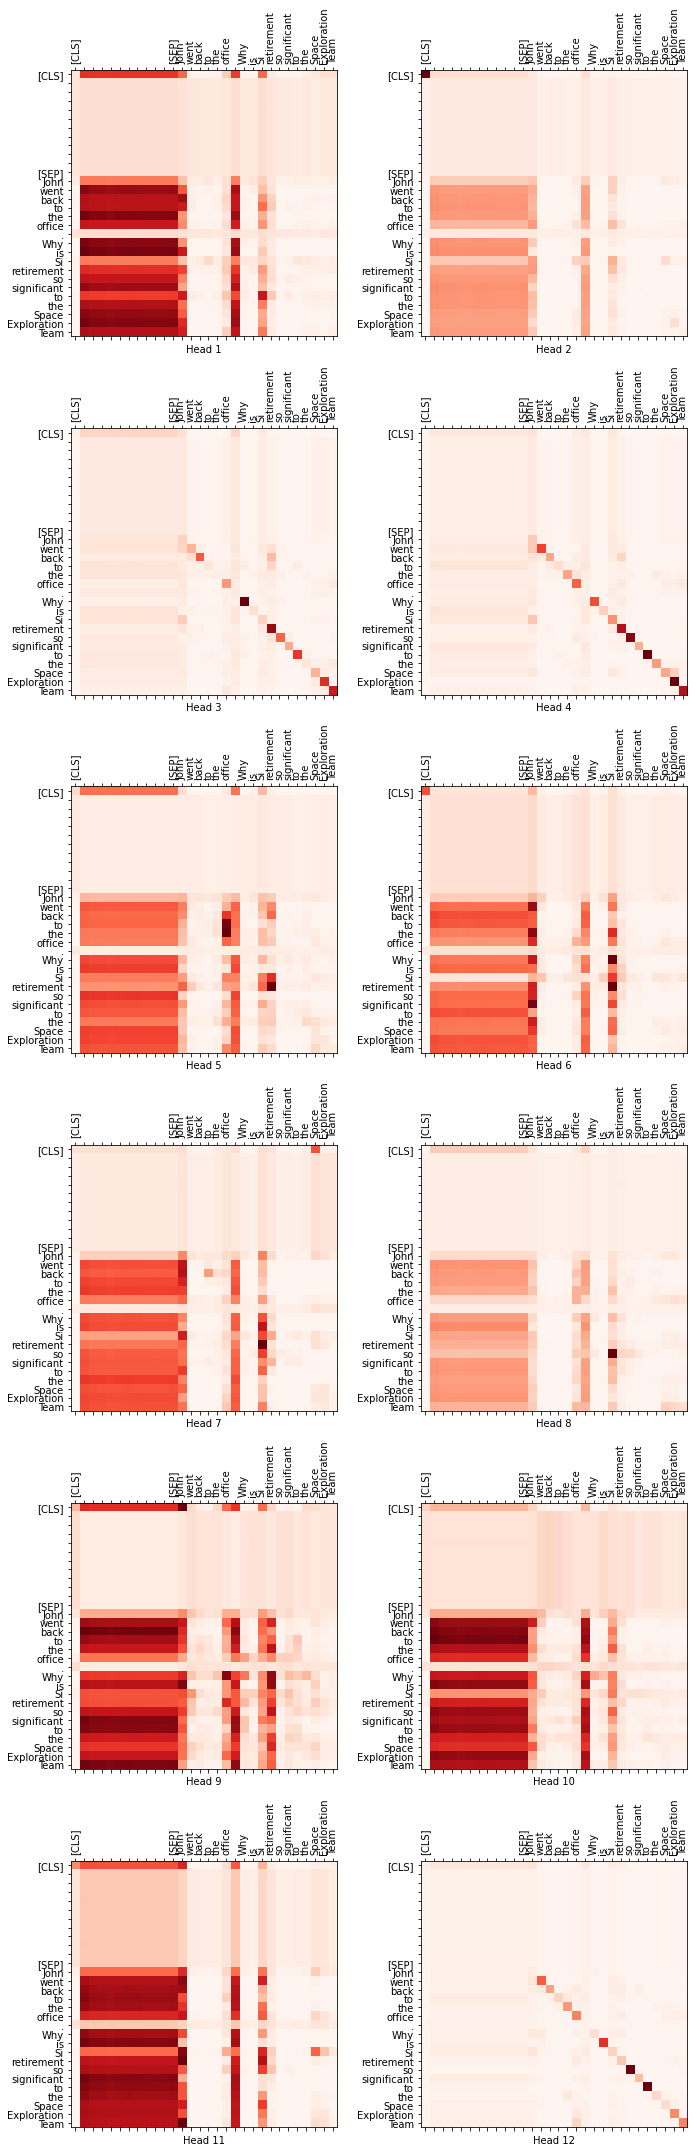

In [51]:
layer = -1
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg2

<Figure size 720x720 with 0 Axes>

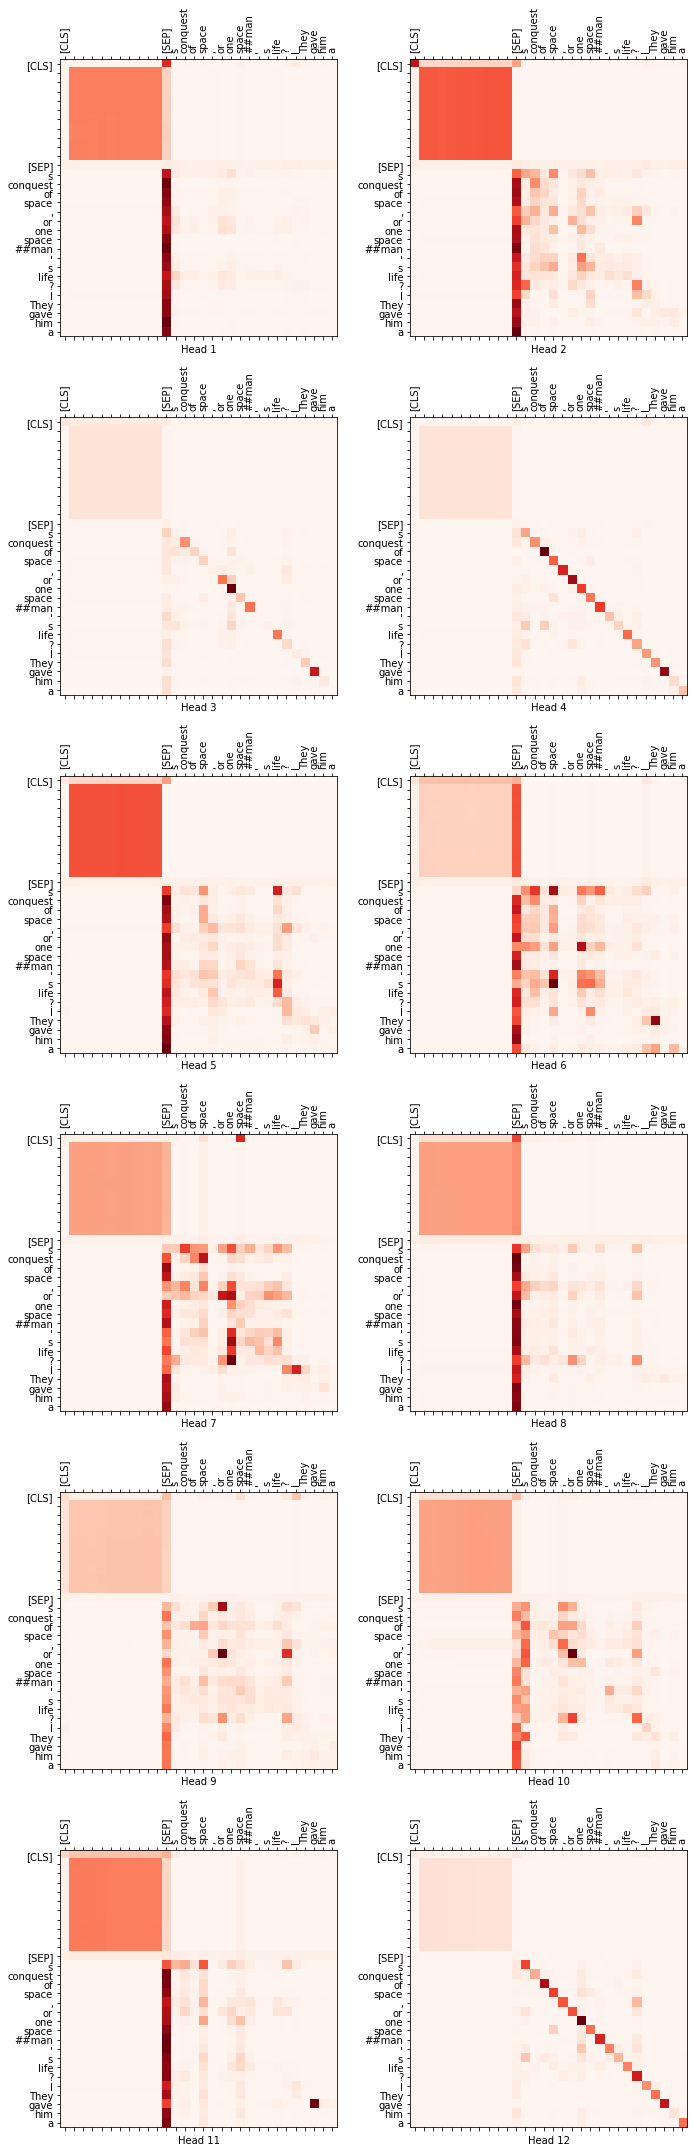

In [52]:
layer = -1
segment = 1
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg3

<Figure size 720x720 with 0 Axes>

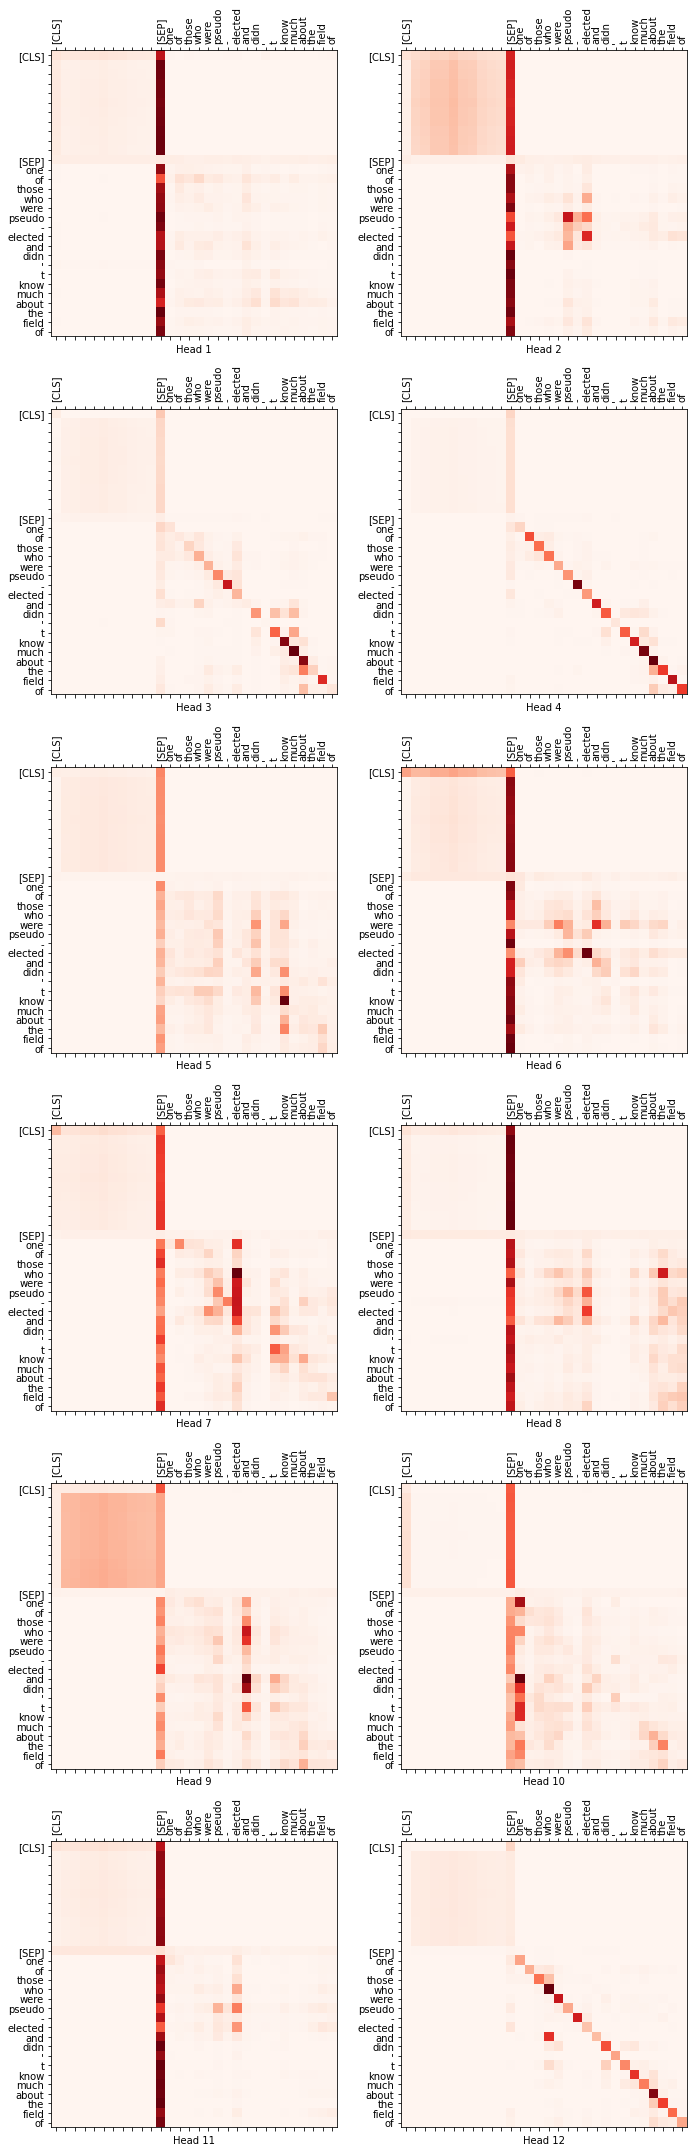

In [53]:
layer = -1
segment = 2
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)
